In [1]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
# 2. Đọc file dữ liệu chứng khoán Eximbank và chia tập train test theo tỉ lệ 7:3
df = pd.read_csv('Eximbank.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12841.994, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12842.562, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12842.612, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12840.641, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12844.444, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.432 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [6]:
# 5. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Tạo một mảng gồm 30 số nguyên liên tiếp bắt đầu từ last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá đóng cho 30 ngày tiếp theo
close_next_30_days = model_fit.forecast(steps=len(x_next_30_days))

y_next_30_days = close_next_30_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 30 ngày tiếp theo
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[21066.66490066 21046.23870774 21029.48856011 21013.88392989
 20998.65573315 20983.57017506 20968.55613116 20953.59191143
 20938.67084875 20923.7908416  20908.95117609 20894.15156021
 20879.39183038 20864.67186223 20849.99154352 20835.3507659
 20820.74942239 20806.18740663 20791.66461265 20777.1809348
 20762.73626772 20748.33050633 20733.96354584 20719.63528175
 20705.34560983 20691.09442613 20676.881627   20662.70710903
 20648.57076913 20634.47250446]


In [7]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 2747.9770980219887


In [8]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 11.7093094050803


In [9]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 2143.3810108217663


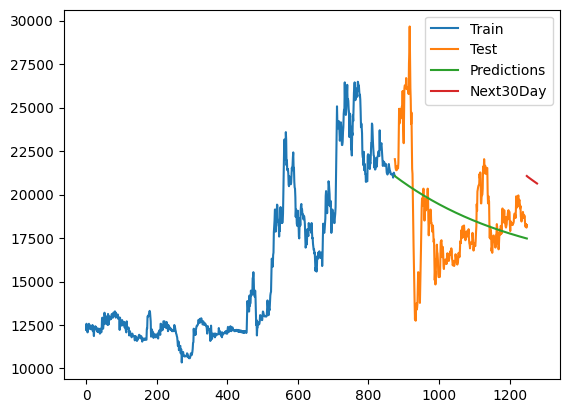

In [10]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

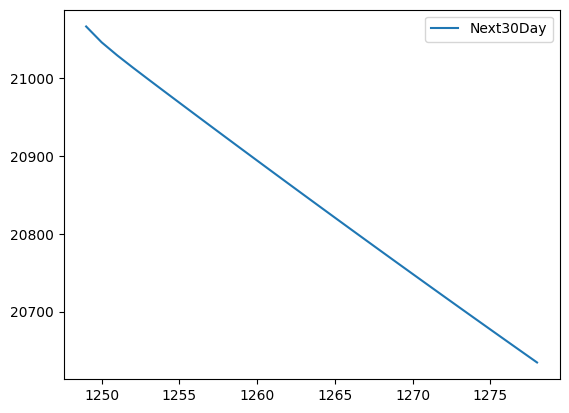

In [11]:
plt.plot(last_data,y_next_30_days)
plt.legend(['Next30Day'])
plt.show()